In [29]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
import random

In [33]:
#import and show CSV file
df = pd.read_csv('./CSV/cb_revenue_data.csv')
df.head(5)

,Date,CHOICE BUILDER
0,12/1/2009,166
1,1/1/2010,613
2,2/1/2010,4040
3,3/1/2010,8340
4,4/1/2010,10335


In [34]:
ts = df.set_index('Date')

In [35]:
ts['CHOICE BUILDER'] = ts['CHOICE BUILDER'].astype(float)

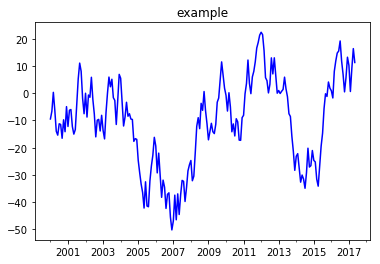

2000-01-31    -9.441351
2000-02-29    -6.574050
2000-03-31     0.353010
2000-04-30    -6.234608
2000-05-31   -13.957423
2000-06-30   -15.387453
2000-07-31   -11.208313
2000-08-31   -11.456912
2000-09-30   -16.540081
2000-10-31    -9.748607
Freq: M, dtype: float64

In [26]:
random.seed(111)
rng = pd.date_range(start = '2000', periods = 209, freq='M')
tst = pd.Series(np.random.uniform(-10,10, size=len(rng)), rng).cumsum()
tst.plot(c='b', title='example')
plt.show()
tst.head(10)

In [36]:
#convert data to array
TS = np.array(ts)
num_periods = 20
f_horizon = 1

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
print (len(x_batches))
print (x_batches.shape)
print (x_batches[0:2])

print (y_batches[0:1])
print (y_batches.shape)

5
(5, 20, 1)
[[[   166.]
  [   613.]
  [  4040.]
  [  8340.]
  [ 10335.]
  [ 11080.]
  [ 10355.]
  [ 30967.]
  [  8582.]
  [ 16413.]
  [  9082.]
  [ 26425.]
  [ 24478.]
  [ 20783.]
  [ 22398.]
  [ 29223.]
  [ 25747.]
  [ 29372.]
  [ 34343.]
  [ 32970.]]

 [[ 36692.]
  [ 40497.]
  [ 42215.]
  [ 40563.]
  [ 44680.]
  [ 39996.]
  [ 66908.]
  [ 54048.]
  [ 59311.]
  [ 62048.]
  [ 67325.]
  [ 72091.]
  [ 66478.]
  [ 73012.]
  [ 82747.]
  [ 76577.]
  [ 83624.]
  [109192.]
  [ 93809.]
  [112564.]]]
[[[  613.]
  [ 4040.]
  [ 8340.]
  [10335.]
  [11080.]
  [10355.]
  [30967.]
  [ 8582.]
  [16413.]
  [ 9082.]
  [26425.]
  [24478.]
  [20783.]
  [22398.]
  [29223.]
  [25747.]
  [29372.]
  [34343.]
  [32970.]
  [36692.]]]
(5, 20, 1)


In [37]:
#pull out test data
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods)
print (X_test.shape)
print (X_test)

(1, 20, 1)
[[[469842.]
  [517473.]
  [514999.]
  [448152.]
  [482915.]
  [541088.]
  [490151.]
  [559046.]
  [498463.]
  [498180.]
  [524680.]
  [557488.]
  [580610.]
  [593037.]
  [624594.]
  [580831.]
  [609855.]
  [601214.]
  [588871.]
  [627123.]]]


In [48]:
tf.reset_default_graph()

num_periods = 20
inputs = 1
hidden = 2000
output = 1

#create variables
X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

#create RNN object
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

learning_rate = 0.001

#change form to tensor / specify type of layer / shape of results
stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


In [51]:
#implement model on training data
epochs = 500

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 ==0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 27405295000000.0
100 	MSE: 181307380000.0
200 	MSE: 23300588000.0
300 	MSE: 13656644000.0
400 	MSE: 6582781000.0
[[[503374.22]
  [514666.28]
  [541594.3 ]
  [564479.75]
  [492593.12]
  [534191.06]
  [572925.7 ]
  [486953.5 ]
  [496140.75]
  [628129.94]
  [496459.5 ]
  [619077.2 ]
  [550321.06]
  [607984.6 ]
  [606525.7 ]
  [621003.5 ]
  [629685.44]
  [602752.56]
  [674557.94]
  [599165.3 ]]]


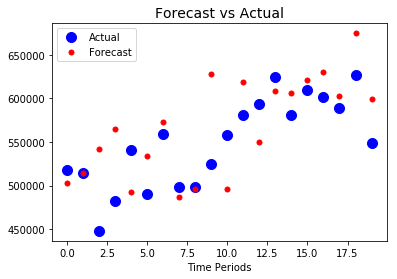

In [52]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label = "Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()